In [1]:
import os
import math
import talib
import random
import pickle
import json
import pandas as pd
import numpy as np
import jqdatasdk as jq
import baostock as bs
import time

from multiprocessing import Pool
from functools import partial
from scipy import signal
from scipy import stats
from datetime import datetime, timedelta
from tqdm import tqdm

import matplotlib.pyplot as plt
from IPython.core.display import HTML, clear_output

%matplotlib inline
%config InlineBackend.figure_format='svg'
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',    5000)

from featureutil2 import FeatureTool
from plotutils import PlotTool
from datagent import BaosAgent
from datagent import DataUtil
from datagent import JQDataUtil
from sfstrategy import SFStrategy

def get_freq_file_sto_ids(freq):
    file_sto_ids = []
    path_src = './data/' + str(freq) + '/'
    files = os.listdir(path_src)
    all_file_sto_id = []
    for file in files:
        if file.endswith('pkl'):
            file_sto_ids.append(file[:6])

    return file_sto_ids

from scipy import stats
def compute_slopes(x):
    slope, intercept, r_value, p_value, std_err = stats.linregress(range(len(x)), x)
    return slope

def align_yaxis(ax1, ax2, base):
    ax1_ymin, ax1_ymax = ax1.get_ylim()
    ax2_ymin, ax2_ymax = ax2.get_ylim()
    new_ax2_ymax = (base-ax2_ymin) / ((base-ax1_ymin) / (ax1_ymax - ax1_ymin)) +  ax2_ymin
    new_ax1_ymax = (base-ax1_ymin) / ((base-ax2_ymin) / (ax2_ymax - ax2_ymin)) +  ax1_ymin
    if new_ax2_ymax >= ax2_ymax:
        ax2.set_ylim(ax2_ymin, new_ax2_ymax)
    else:
        ax1.set_ylim(ax1_ymin, new_ax1_ymax)

In [2]:
%%time

def find_engouh_data_sto_ids(sub_sto_ids, start_date):
    sub_obs_sto_ids = []
    for sto_id in tqdm(sub_sto_ids):
        tmp_df = BaosAgent.read_freq_df(delta, sto_id)
        begin_date = tmp_df.iloc[0].date
        if begin_date <= bg_date:
            # print(sto_id, begin_date)
            sub_obs_sto_ids.append(sto_id)
    return sub_obs_sto_ids

def find_engouh_data_sto_ids_callback(rlts):
    obs_sto_ids = []
    for rlt in rlts:
        obs_sto_ids.extend(rlt)
    return obs_sto_ids

delta = 15
all_sto_ids = get_freq_file_sto_ids(delta)

NUM_PROCESS = 5
size = math.ceil(len(all_sto_ids) / NUM_PROCESS)
sub_seqs = []
for proc_idx in range(NUM_PROCESS):
    start_idx = size * proc_idx
    stop_idx = size * (proc_idx + 1)
    sub_seq = all_sto_ids[start_idx:stop_idx]
    sub_seqs.append(sub_seq)

bg_date = (datetime.now() - timedelta(days=365 * 3)).strftime("%Y-%m-%d")
with Pool(NUM_PROCESS) as pool:
    rlts = pool.map(partial(find_engouh_data_sto_ids, start_date=bg_date), sub_seqs)
    obs_sto_ids = find_engouh_data_sto_ids_callback(rlts)
    print("obs_sto_ids:", len(obs_sto_ids))

100%|██████████| 694/694 [00:16<00:00, 41.92it/s]


obs_sto_ids: 2987
CPU times: user 428 ms, sys: 327 ms, total: 755 ms
Wall time: 16.6 s


In [52]:
def plot_df(tmp_df):
    fig = plt.figure(figsize=(len(tmp_df)/128, 35))
    fig.patch.set_facecolor('#2A2A2A')
    xaxis_idxes = tmp_df.time.str[:4] + '-' + tmp_df.time.str[4:6] + '-' + tmp_df.time.str[6:8] + ' ' + tmp_df.time.str[8:10] + ':' + tmp_df.time.str[10:12]
    x_axis_slice = slice(0, -1, daily_count * 5 * 4)

    ############## subplot 1 ##############
#     ax = plt.subplot(7,1,1)
#     PlotTool.custom_ax(ax)
#     for col in tmp_df.columns:
#         if col.startswith('vol_1t_sum_last_'):
#             ax.plot(xaxis_idxes, tmp_df[col], lw=.2, color='cyan')
#     PlotTool.custom_axticks(ax, xaxis_idxes, x_axis_slice)

#     ax2 = ax.twinx()
#     PlotTool.custom_ax(ax2)
#     ax2.plot(xaxis_idxes, tmp_df.close, color='orange', lw=.5)
#     for col in tmp_df.columns:
#         if col.startswith('closema_'):
#             ax2.plot(xaxis_idxes, tmp_df[col], lw=.2, color='orange')
#     # minp, maxp = np.min(tmp_df.close), np.max(tmp_df.close)
#     # for cond_idx in tmp_df[cond_vup_pup].index:
#     #     ax2.vlines(tmp_df.index[cond_vup_pup], minp, maxp, lw=.5, color='orange')
#     # for cond_idx in tmp_df[cond_vup_pdn].index:
#     #     ax2.vlines(tmp_df.index[cond_vup_pdn], minp, maxp, lw=.5, color='lime')
#     PlotTool.custom_axticks(ax2, xaxis_idxes, x_axis_slice)

    ############## subplot 2 ##############
#     ax = plt.subplot(7,1,2)
#     PlotTool.custom_ax(ax)
#     cols = []
#     for col in tmp_df.columns:
#         if col.startswith("closema_"):
#             cols.append(col)
#     tmp_df['close_ma_idx'] = 0
#     first_idx = 0
#     for idx in range(first_idx, len(cols) - 1):
#         tmp_df.loc[tmp_df[cols[idx]] > tmp_df[cols[idx+1]], 'close_ma_idx'] += 1
#     ax.plot(xaxis_idxes, tmp_df.close_ma_idx, lw=.5, color='gold')

#     cols = []
#     for col in tmp_df.columns:
#         if col.startswith("volma_"):
#             cols.append(col)
#     tmp_df['vol_ma_idx'] = 0
#     first_idx = 0
#     for idx in range(first_idx, len(cols) - 1):
#         tmp_df.loc[tmp_df[cols[idx]] > tmp_df[cols[idx+1]], 'vol_ma_idx'] += 1
#     ax.plot(xaxis_idxes, tmp_df.vol_ma_idx, lw=.5, color='cyan')
#     PlotTool.custom_axticks(ax, xaxis_idxes, x_axis_slice)

#     ax2 = ax.twinx()
#     PlotTool.custom_ax(ax2)
#     ax2.plot(xaxis_idxes, tmp_df.close, color='orange', lw=.5)
#     for col in tmp_df.columns:
#         if col.startswith('closema_'):
#             ax2.plot(xaxis_idxes, tmp_df[col], lw=.2, color='orange')
#     PlotTool.custom_axticks(ax2, xaxis_idxes, x_axis_slice)

    ############## subplot 3 ##############
    ax = plt.subplot(7,1,3)
    PlotTool.custom_ax(ax)
    for col in tmp_df.columns:
        if col.startswith('volma_'):
            ax.plot(xaxis_idxes, tmp_df[col], lw=.1, color='cyan')
    PlotTool.custom_axticks(ax, xaxis_idxes, x_axis_slice)
    ax2 = ax.twinx()
    PlotTool.custom_ax(ax2)
    ax2.plot(xaxis_idxes, tmp_df.close, color='orange', lw=.5)
    for col in tmp_df.columns:
        if col.startswith('closema_'):
            ax2.plot(xaxis_idxes, tmp_df[col], lw=.2, color='orange')
    PlotTool.custom_axticks(ax2, xaxis_idxes, x_axis_slice)

    ############## subplot 4 ##############
    ax = plt.subplot(7,1,4)
    PlotTool.custom_ax(ax)
#     for col in tmp_df.columns:
#         if col.startswith('k_') and col.endswith('d'):
#             ax.plot(xaxis_idxes, tmp_df[col], lw=.3, color='cyan')
    ax.plot(xaxis_idxes, tmp_df.k_01d, lw=.3, color='cyan')
    ax.plot(xaxis_idxes, tmp_df.d_01d, lw=.6, color='cyan')
    ax.plot(xaxis_idxes, tmp_df.k_05d, lw=.3, color='lime')
    ax.plot(xaxis_idxes, tmp_df.d_05d, lw=.6, color='lime')
#     ax.plot(xaxis_idxes, tmp_df.k_10d, lw=.3, color='cyan')
#     ax.plot(xaxis_idxes, tmp_df.k_15d, lw=.3, color='cyan')
#     ax.plot(xaxis_idxes, tmp_df.k_20d, lw=.3, color='cyan')
#     ax.plot(xaxis_idxes, tmp_df.k_25d, lw=.3, color='cyan')
#     ax.plot(xaxis_idxes, tmp_df.k_30d, lw=.3, color='cyan')
#     ax.plot(xaxis_idxes, tmp_df['k_sum'], lw=1, color='cyan')
    ax.hlines(80, xmin=min(xaxis_idxes), xmax=max(xaxis_idxes), color='w', lw=.2)
    ax.hlines(50, xmin=min(xaxis_idxes), xmax=max(xaxis_idxes), color='w', lw=.2)
    ax.hlines(20, xmin=min(xaxis_idxes), xmax=max(xaxis_idxes), color='w', lw=.2)
    PlotTool.custom_axticks(ax, xaxis_idxes, x_axis_slice)
    ax2 = ax.twinx()
    PlotTool.custom_ax(ax2)
    ax2.plot(xaxis_idxes, tmp_df.close, color='orange', lw=.5)
#     for col in tmp_df.columns:
#         if col.startswith('closema_'):
#             ax2.plot(xaxis_idxes, tmp_df[col], lw=.2, color='orange')
    
#     cond_k_up = (tmp_df.k_05d > tmp_df.k_05d.shift(1))
#     cond_k_up = (tmp_df.k_06d > tmp_df.k_06d.shift(1)) & cond_k_up
#     cond_k_up = (tmp_df.k_07d > tmp_df.k_07d.shift(1)) & cond_k_up
#     cond_k_up = (tmp_df.k_08d > tmp_df.k_08d.shift(1)) & cond_k_up
#     cond_k_up = (tmp_df.k_09d > tmp_df.k_09d.shift(1)) & cond_k_up
    cond_k_up = (tmp_df.k_10d > tmp_df.k_10d.shift(1))# & cond_k_up
    cond_k_up = (tmp_df.k_11d > tmp_df.k_11d.shift(1)) & cond_k_up
    cond_k_up = (tmp_df.k_12d > tmp_df.k_12d.shift(1)) & cond_k_up
    cond_k_up = (tmp_df.k_13d > tmp_df.k_13d.shift(1)) & cond_k_up
    cond_k_up = (tmp_df.k_14d > tmp_df.k_14d.shift(1)) & cond_k_up
    cond_k_up = (tmp_df.k_15d > tmp_df.k_15d.shift(1)) & cond_k_up
    cond_k_up = (tmp_df.k_16d > tmp_df.k_16d.shift(1)) & cond_k_up
    cond_k_up = (tmp_df.k_17d > tmp_df.k_17d.shift(1)) & cond_k_up
    cond_k_up = (tmp_df.k_18d > tmp_df.k_18d.shift(1)) & cond_k_up
    cond_k_up = (tmp_df.k_19d > tmp_df.k_19d.shift(1)) & cond_k_up
    cond_k_up = (tmp_df.k_20d > tmp_df.k_20d.shift(1)) & cond_k_up
    cond_k_up = (tmp_df.k_21d > tmp_df.k_21d.shift(1)) & cond_k_up
    cond_k_up = (tmp_df.k_22d > tmp_df.k_22d.shift(1)) & cond_k_up
    cond_k_up = (tmp_df.k_23d > tmp_df.k_23d.shift(1)) & cond_k_up
    cond_k_up = (tmp_df.k_24d > tmp_df.k_24d.shift(1)) & cond_k_up
    cond_k_up = (tmp_df.k_25d > tmp_df.k_25d.shift(1)) & cond_k_up
    cond_k_up = (tmp_df.k_26d > tmp_df.k_26d.shift(1)) & cond_k_up
    cond_k_up = (tmp_df.k_27d > tmp_df.k_27d.shift(1)) & cond_k_up
    cond_k_up = (tmp_df.k_28d > tmp_df.k_28d.shift(1)) & cond_k_up
    cond_k_up = (tmp_df.k_29d > tmp_df.k_29d.shift(1)) & cond_k_up
    cond_k_up = (tmp_df.k_30d > tmp_df.k_30d.shift(1)) & cond_k_up
    target_idxes = tmp_df[cond_k_up].index
#     cond = (tmp_df.k_01d > tmp_df.k_01d.shift(1)) & (tmp_df.k_01d.shift(2) > tmp_df.k_01d.shift(1)) & cond_k_up
#     cps   = tmp_df.iloc[tmp_df[cond].index].close
#     k01ds = tmp_df.iloc[tmp_df[cond].index].k_01d
    
#     df = pd.concat([cps, k01ds], axis=1)
#     target_idxes = df[(df.close < df.close.shift(1)) & (df.k_01d > df.k_01d.shift(1))].index
#     print("k:{}".format(len(target_idxes)))

#     cond = tmp_df.k_05d > tmp_df.d_05d
#     cond = cond & (tmp_df.k_01d > tmp_df.d_01d) & (tmp_df.k_01d.shift(1) < tmp_df.d_01d.shift(1))
#     target_idxes = tmp_df[cond].index
    cond = (tmp_df.k_01d > tmp_df.d_01d) & (tmp_df.k_01d.shift(1) < tmp_df.d_01d.shift(1))
    idxes = tmp_df[cond].index
    for target_idx in idxes:
        ax2.vlines(xaxis_idxes[target_idx], np.min(tmp_df.close), np.max(tmp_df.close), lw=.2, color='yellow')

    obs_idxes = []
    for idx in range(len(idxes) - 1):
        pre_idx = idxes[idx]
        cur_idx = idxes[idx+1]
        if tmp_df.iloc[pre_idx].k_01d < tmp_df.iloc[cur_idx].k_01d and tmp_df.iloc[pre_idx].k_05d > tmp_df.iloc[pre_idx].d_05d and tmp_df.iloc[cur_idx].k_05d > tmp_df.iloc[cur_idx].d_05d:
            obs_idxes.append(cur_idx)
            print(tmp_df.iloc[pre_idx].close, tmp_df.iloc[cur_idx].close)
            print(tmp_df.iloc[pre_idx-1].k_01d, tmp_df.iloc[pre_idx-1].d_01d, tmp_df.iloc[pre_idx].k_01d, tmp_df.iloc[pre_idx].d_01d)
            print(tmp_df.iloc[cur_idx-1].k_01d, tmp_df.iloc[cur_idx-1].d_01d, tmp_df.iloc[cur_idx].k_01d, tmp_df.iloc[cur_idx].d_01d)
    for target_idx in obs_idxes:
        ax2.vlines(xaxis_idxes[target_idx], np.min(tmp_df.close), np.max(tmp_df.close), lw=1, color='yellow')
    PlotTool.custom_axticks(ax2, xaxis_idxes, x_axis_slice)

    ############## subplot 5 ##############
    ax = plt.subplot(7,1,5)
    PlotTool.custom_ax(ax)
#     for col in tmp_df.columns:
#         if col.startswith('macdhist_') and col.endswith('d'):
#             ax.plot(xaxis_idxes, tmp_df[col], lw=.3, color='cyan')
    ax.plot(xaxis_idxes, tmp_df.macdhist_01d, lw=.3, color='cyan')
    ax.plot(xaxis_idxes, tmp_df.macdhist_05d, lw=.3, color='cyan')
    ax.plot(xaxis_idxes, tmp_df.macdhist_10d, lw=.3, color='cyan')
    ax.plot(xaxis_idxes, tmp_df.macdhist_15d, lw=.3, color='cyan')
    ax.plot(xaxis_idxes, tmp_df.macdhist_20d, lw=.3, color='cyan')
#     ax.plot(xaxis_idxes, tmp_df.macdhist_25d, lw=.3, color='cyan')
#     ax.plot(xaxis_idxes, tmp_df.macdhist_30d, lw=.3, color='cyan')
    
    ax.plot(xaxis_idxes, tmp_df['macdhist_sum'], lw=1, color='cyan')
    ax.hlines(0, xmin=min(xaxis_idxes), xmax=max(xaxis_idxes), color='w', lw=.2)
    PlotTool.custom_axticks(ax, xaxis_idxes, x_axis_slice)
    ax2 = ax.twinx()
    PlotTool.custom_ax(ax2)
    ax2.plot(xaxis_idxes, tmp_df.close, color='orange', lw=.5)

#     cond_macdhist_up = (tmp_df.macdhist_05d > tmp_df.macdhist_05d.shift(1))
#     cond_macdhist_up = (tmp_df.macdhist_06d > tmp_df.macdhist_06d.shift(1)) & cond_macdhist_up
#     cond_macdhist_up = (tmp_df.macdhist_07d > tmp_df.macdhist_07d.shift(1)) & cond_macdhist_up
#     cond_macdhist_up = (tmp_df.macdhist_08d > tmp_df.macdhist_08d.shift(1)) & cond_macdhist_up
#     cond_macdhist_up = (tmp_df.macdhist_09d > tmp_df.macdhist_09d.shift(1)) & cond_macdhist_up
#     cond_macdhist_up = (tmp_df.macdhist_10d > tmp_df.macdhist_10d.shift(1))# & cond_macdhist_up
#     cond_macdhist_up = (tmp_df.macdhist_11d > tmp_df.macdhist_11d.shift(1)) & cond_macdhist_up
#     cond_macdhist_up = (tmp_df.macdhist_12d > tmp_df.macdhist_12d.shift(1)) & cond_macdhist_up
#     cond_macdhist_up = (tmp_df.macdhist_13d > tmp_df.macdhist_13d.shift(1)) & cond_macdhist_up
#     cond_macdhist_up = (tmp_df.macdhist_14d > tmp_df.macdhist_14d.shift(1)) & cond_macdhist_up
#     cond_macdhist_up = (tmp_df.macdhist_15d > tmp_df.macdhist_15d.shift(1)) & cond_macdhist_up
#     cond_macdhist_up = (tmp_df.macdhist_16d > tmp_df.macdhist_16d.shift(1)) & cond_macdhist_up
#     cond_macdhist_up = (tmp_df.macdhist_17d > tmp_df.macdhist_17d.shift(1)) & cond_macdhist_up
#     cond_macdhist_up = (tmp_df.macdhist_18d > tmp_df.macdhist_18d.shift(1)) & cond_macdhist_up
#     cond_macdhist_up = (tmp_df.macdhist_19d > tmp_df.macdhist_19d.shift(1)) & cond_macdhist_up
#     cond_macdhist_up = (tmp_df.macdhist_20d > tmp_df.macdhist_20d.shift(1)) & cond_macdhist_up
#     cond_macdhist_up = (tmp_df.macdhist_21d > tmp_df.macdhist_21d.shift(1)) & cond_macdhist_up
#     cond_macdhist_up = (tmp_df.macdhist_22d > tmp_df.macdhist_22d.shift(1)) & cond_macdhist_up
#     cond_macdhist_up = (tmp_df.macdhist_23d > tmp_df.macdhist_23d.shift(1)) & cond_macdhist_up
#     cond_macdhist_up = (tmp_df.macdhist_24d > tmp_df.macdhist_24d.shift(1)) & cond_macdhist_up
#     cond_macdhist_up = (tmp_df.macdhist_25d > tmp_df.macdhist_25d.shift(1)) & cond_macdhist_up
#     cond_macdhist_up = (tmp_df.macdhist_26d > tmp_df.macdhist_26d.shift(1)) & cond_macdhist_up
#     cond_macdhist_up = (tmp_df.macdhist_27d > tmp_df.macdhist_27d.shift(1)) & cond_macdhist_up
#     cond_macdhist_up = (tmp_df.macdhist_28d > tmp_df.macdhist_28d.shift(1)) & cond_macdhist_up
#     cond_macdhist_up = (tmp_df.macdhist_29d > tmp_df.macdhist_29d.shift(1)) & cond_macdhist_up
#     cond_macdhist_up = (tmp_df.macdhist_30d > tmp_df.macdhist_30d.shift(1)) & cond_macdhist_up
#     target_idxes = tmp_df[cond_macdhist_up].index
#     cond = (tmp_df.macdhist_01d > tmp_df.macdhist_01d.shift(1)) & (tmp_df.macdhist_01d.shift(2) > tmp_df.macdhist_01d.shift(1)) & cond_macdhist_up
#     cps    = tmp_df.iloc[tmp_df[cond].index].close
#     mh01ds = tmp_df.iloc[tmp_df[cond].index].macdhist_01d
#     df = pd.concat([cps, mh01ds], axis=1)
#     target_idxes = df[(df.close < df.close.shift(1)) & (df.macdhist_01d > df.macdhist_01d.shift(1))].index
#     print("macdhist:{}".format(len(target_idxes)))
#     for target_idx in target_idxes:
#         ax2.vlines(xaxis_idxes[target_idx], np.min(tmp_df.close), np.max(tmp_df.close), lw=.2, color='yellow')
    PlotTool.custom_axticks(ax2, xaxis_idxes, x_axis_slice)
    
    ############## subplot 6 ##############
#     ax = plt.subplot(7,1,6)
#     PlotTool.custom_ax(ax)
# #     for col in tmp_df.columns:
# #         if col.startswith('mfi_') and col.endswith('d'):
# #             ax.plot(xaxis_idxes, tmp_df[col], lw=.2, color='cyan')
# #     ax.plot(xaxis_idxes, tmp_df['mfi_01d'], lw=.1, color='cyan')

# #     ax.fill_between(xaxis_idxes, tmp_df.mfi_05d, 50, where=tmp_df.mfi_05d > 50, facecolor='orange', alpha=0.3)
# #     ax.fill_between(xaxis_idxes, 50, tmp_df.mfi_05d, where=tmp_df.mfi_05d < 50, facecolor='lime',   alpha=0.3)

#     ax.fill_between(xaxis_idxes, tmp_df.mfi_01d, 50, where=tmp_df.mfi_01d > 50, facecolor='orange', alpha=0.3)
#     ax.fill_between(xaxis_idxes, 50, tmp_df.mfi_01d, where=tmp_df.mfi_01d < 50, facecolor='lime',   alpha=0.3)
#     ax.hlines(80, xmin=min(xaxis_idxes), xmax=max(xaxis_idxes), color='w', lw=.3)
# #     ax.hlines(50, xmin=min(xaxis_idxes), xmax=max(xaxis_idxes), color='w', lw=.3)
#     ax.hlines(20, xmin=min(xaxis_idxes), xmax=max(xaxis_idxes), color='w', lw=.3)
    
# #     ax.hlines(50, xmin=min(xaxis_idxes), xmax=max(xaxis_idxes), color='w', lw=.1)
#     PlotTool.custom_axticks(ax, xaxis_idxes, x_axis_slice)
#     ax2 = ax.twinx()
#     PlotTool.custom_ax(ax2)
#     ax2.plot(xaxis_idxes, tmp_df.close, color='orange', lw=.5)
# #     for col in tmp_df.columns:
# #         if col.startswith('closema_'):
# #             ax2.plot(xaxis_idxes, tmp_df[col], lw=.2, color='orange')
#     PlotTool.custom_axticks(ax2, xaxis_idxes, x_axis_slice)
    
    ############## subplot 7 ##############
#     ax = plt.subplot(7,1,7)
#     PlotTool.custom_ax(ax)
#     ax.plot(xaxis_idxes, np.gradient(tmp_df.macdhist_02d), color='cyan', lw=.5)
#     ax.hlines(0, xmin=min(tmp_df.index), xmax=max(tmp_df.index), color='w', lw=.5)
#     PlotTool.custom_axticks(ax, xaxis_idxes, x_axis_slice)

#     ax2 = ax.twinx()
#     PlotTool.custom_ax(ax2)
#     ax2.plot(xaxis_idxes, tmp_df.close, color='orange', lw=.5)
#     PlotTool.custom_axticks(ax2, xaxis_idxes, x_axis_slice)

    plt.show()

In [60]:
# jq.auth('15808061188', 'allan2jq')
# clear_output()
# jq.get_query_count()

delta = 15
daily_count = int(240/delta)
tmp_sto_id = random.sample(obs_sto_ids,1)[0]

tmp_df = BaosAgent.read_freq_df(delta, tmp_sto_id)
# tmp_df = DataUtil.add_rt_data(tmp_sto_id, tmp_df, delta, JQDataUtil.get_end_ts(delta))
begin_date = tmp_df.iloc[0].date
tmp_df = FeatureTool.add_close_vol_ma(tmp_df, daily_count)
tmp_df = FeatureTool.add_kds_indicators(tmp_df, daily_count)
tmp_df = FeatureTool.add_macd_indicators(tmp_df, daily_count)
tmp_df = FeatureTool.add_mfi_indicators(tmp_df, daily_count)
# tmp_df = tmp_df.iloc[-daily_count*5*60:]
tmp_df = tmp_df.dropna()
tmp_df = tmp_df.reset_index(drop=True)

bs.login()
bs_sto_id = BaosAgent.get_baostock_sto_id(tmp_sto_id)
sto_name = bs.query_stock_basic(code=bs_sto_id).get_row_data()[1]
print(tmp_sto_id, sto_name, begin_date, tmp_df.iloc[0].date, tmp_df.iloc[-1].date)
bs.logout()

plot_df(tmp_df)

002353 杰瑞股份 2015-01-05 2018-04-20 2020-03-17
logout success!
15.73 17.66
13.835916253830499 14.745964381711774 14.620272503378681 14.545684298967657
78.06332330274397 78.46262438895421 78.57338570970607 78.35238953424081
16.65 17.45
68.66996281261015 68.68851793457426 68.93183775120922 68.48260092492946
69.2073754789278 69.24544236556481 69.28126710454357 69.21180098663841
17.45 18.1
69.2073754789278 69.24544236556481 69.28126710454357 69.21180098663841
76.27312936916248 76.88326449432135 76.80909803013112 76.76022404868904
18.1 18.54
76.27312936916248 76.88326449432135 76.80909803013112 76.76022404868904
75.82921810541758 76.98674381793386 76.85754054550473 76.84269577476617
18.94 19.11
52.77447686183942 52.96493887106187 54.61379283514231 52.647680991939666
62.88672654690674 62.975296654389126 63.14246506986083 62.753292401139
21.44 22.5
63.892484233643074 64.07436162039956 64.15372981277658 63.87524865538569
77.81843486024222 78.01725618761246 78.08027965374414 78.00068893575124
17.

In [61]:
%run MF_Util.ipynb

import re
import requests

In [62]:
def get_latest_sums(mfs):
    sums = []
    for idx in range(len(mfs)):
        sub_sum = mfs.iloc[:idx+1].sum()
        sums.append(sub_sum)
    return sums

In [66]:
all_sto_ids = get_freq_file_sto_ids(15)

In [80]:
%run MF_Util.ipynb

import re
import requests

def display_sto_info(sto_id):
    bs.login()
    bs_sto_id = BaosAgent.get_baostock_sto_id(sto_id)
    sto_name = bs.query_stock_basic(code=bs_sto_id).get_row_data()[1]
    print(sto_id, sto_name)
#     bs.logout()

def get_latest_sums(mfs):
    sums = []
    for idx in range(len(mfs)):
        sub_sum = mfs.iloc[:idx+1].sum()
        sums.append(sub_sum)
    return sums

def prepare_mf_data(sto_id, days):
    dates, closes, chgrts, slarges, larges, middles, smalls, sum_mios = get_mf_from_sina(sto_id, days)
    arrays = np.array([dates, closes, slarges, larges, middles, smalls])
    mf_df = pd.DataFrame(data=arrays.transpose(), columns=['dates', 'closes', 'slarges', 'larges', 'middles', 'smalls'])
    mf_df = mf_df.astype({'closes':float, 'slarges':float, 'larges':float, 'middles':float, 'smalls':float})
    slarges_sum = get_latest_sums(mf_df.slarges)
    larges_sum = get_latest_sums(mf_df.larges)
    middles_sum = get_latest_sums(mf_df.middles)
    smalls_sum = get_latest_sums(mf_df.smalls)
    
    mf_df['slarges_sum'] = slarges_sum
    mf_df['larges_sum'] = larges_sum
    mf_df['middles_sum'] = middles_sum
    mf_df['smalls_sum'] = smalls_sum
    
    return mf_df

def plot_mf(sto_id, mf_df):

    fig = plt.figure(figsize=(36, 8))
    fig.patch.set_facecolor('#2A2A2A')
    xaxis_idxes = mf_df.dates
    x_axis_slice = slice(0, -1, 20)

    ############## subplot 1 ##############
    ax = plt.subplot(2,1,1)
    PlotTool.custom_ax(ax)
    ax.bar(xaxis_idxes, mf_df.slarges, facecolor='orangered', alpha=.5)
    ax.bar(xaxis_idxes, mf_df.larges,  facecolor='lime',   alpha=.5)
    # ax.bar(dates, mf_df.middles, facecolor='cyan',   alpha=.5)
    # ax.fill_between(dates, mf_df.smalls , facecolor='lime', alpha=.2)

    PlotTool.custom_axticks(ax, xaxis_idxes, x_axis_slice)
    ax2 = ax.twinx()
    PlotTool.custom_ax(ax2)
    ax2.plot(xaxis_idxes, mf_df.closes, color='orange', lw=.5)
    # ax2.hlines(17.17, xmin=min(dates), xmax=max(dates), color='w', lw=.5)
    PlotTool.custom_axticks(ax2, xaxis_idxes, x_axis_slice)

    ############## subplot 2 ##############
    ax = plt.subplot(2,1,2)
    PlotTool.custom_ax(ax)
    ax.plot(xaxis_idxes, mf_df.slarges_sum, color='orangered', lw=.5)
    ax.plot(xaxis_idxes, mf_df.larges_sum,  color='yellow', lw=.5)
    ax.plot(xaxis_idxes, mf_df.middles_sum, color='cyan',   lw=.5)
    ax.plot(xaxis_idxes, mf_df.smalls_sum , color='lime',   lw=.5)
    ax.hlines(0, xmin=min(xaxis_idxes), xmax=max(xaxis_idxes), color='w', lw=.5)
    PlotTool.custom_axticks(ax, xaxis_idxes, x_axis_slice)
    ax2 = ax.twinx()
    PlotTool.custom_ax(ax2)
    ax2.plot(xaxis_idxes, mf_df.closes, color='orange', lw=.5)
    PlotTool.custom_axticks(ax2, xaxis_idxes, x_axis_slice)

    plt.show()
    plt.close('all')
    
def plot_ta(tmp_df):
    fig = plt.figure(figsize=(36, 8))
    fig.patch.set_facecolor('#2A2A2A')
    xaxis_idxes = tmp_df.time.str[:4] + '-' + tmp_df.time.str[4:6] + '-' + tmp_df.time.str[6:8] + ' ' + tmp_df.time.str[8:10] + ':' + tmp_df.time.str[10:12]
    x_axis_slice = slice(0, -1, daily_count * 5 * 4)

    ############## subplot 1 ##############
    ax = plt.subplot(2,1,1)
    PlotTool.custom_ax(ax)
    ax.fill_between(xaxis_idxes, tmp_df.volume/100, facecolor='cyan', alpha=0.3)
    PlotTool.custom_axticks(ax, xaxis_idxes, x_axis_slice)
    ax2 = ax.twinx()
    PlotTool.custom_ax(ax2)
    ax2.plot(xaxis_idxes, tmp_df.close, color='orange', lw=.5)
    PlotTool.custom_axticks(ax2, xaxis_idxes, x_axis_slice)

    ############## subplot 2 ##############
    ax = plt.subplot(2,1,2)
    PlotTool.custom_ax(ax)
    ax.plot(xaxis_idxes, tmp_df.k_01d, lw=.3, color='cyan')
    ax.plot(xaxis_idxes, tmp_df.d_01d, lw=.6, color='cyan')
    ax.plot(xaxis_idxes, tmp_df.k_05d, lw=.3, color='cyan')
    ax.plot(xaxis_idxes, tmp_df.d_05d, lw=.6, color='cyan')
    ax.hlines(80, xmin=min(xaxis_idxes), xmax=max(xaxis_idxes), color='w', lw=.2)
    ax.hlines(50, xmin=min(xaxis_idxes), xmax=max(xaxis_idxes), color='w', lw=.2)
    ax.hlines(20, xmin=min(xaxis_idxes), xmax=max(xaxis_idxes), color='w', lw=.2)
    ax.fill_between(xaxis_idxes, 50, tmp_df.d_01d, where=tmp_df.d_01d > 50, facecolor='gold', alpha=0.3)
    ax.fill_between(xaxis_idxes, 50, tmp_df.d_01d, where=tmp_df.d_01d < 50, facecolor='lime', alpha=0.3)
    ax.fill_between(xaxis_idxes, 50, tmp_df.d_05d, where=tmp_df.d_05d > 50, facecolor='gold', alpha=0.3)
    ax.fill_between(xaxis_idxes, 50, tmp_df.d_05d, where=tmp_df.d_05d < 50, facecolor='lime', alpha=0.3)
    
    PlotTool.custom_axticks(ax, xaxis_idxes, x_axis_slice)

    ax2 = ax.twinx()
    PlotTool.custom_ax(ax2)
    ax2.plot(xaxis_idxes, tmp_df.close, color='orange', lw=.5)
    # target_ts = alternative_sto_infos[sto_id]['ts']
    # target_idxes = tmp_df[tmp_df.time.isin(target_ts)].index
    # min_y, max_y = np.min(tmp_df.close), np.max(tmp_df.close)
    # for target_idx in target_idxes:
    #     ax2.vlines(xaxis_idxes[target_idx], min_y, max_y, lw=.2, color='yellow')
    PlotTool.custom_axticks(ax2, xaxis_idxes, x_axis_slice)

    plt.show()

    plt.close('all')


002223 鱼跃医疗


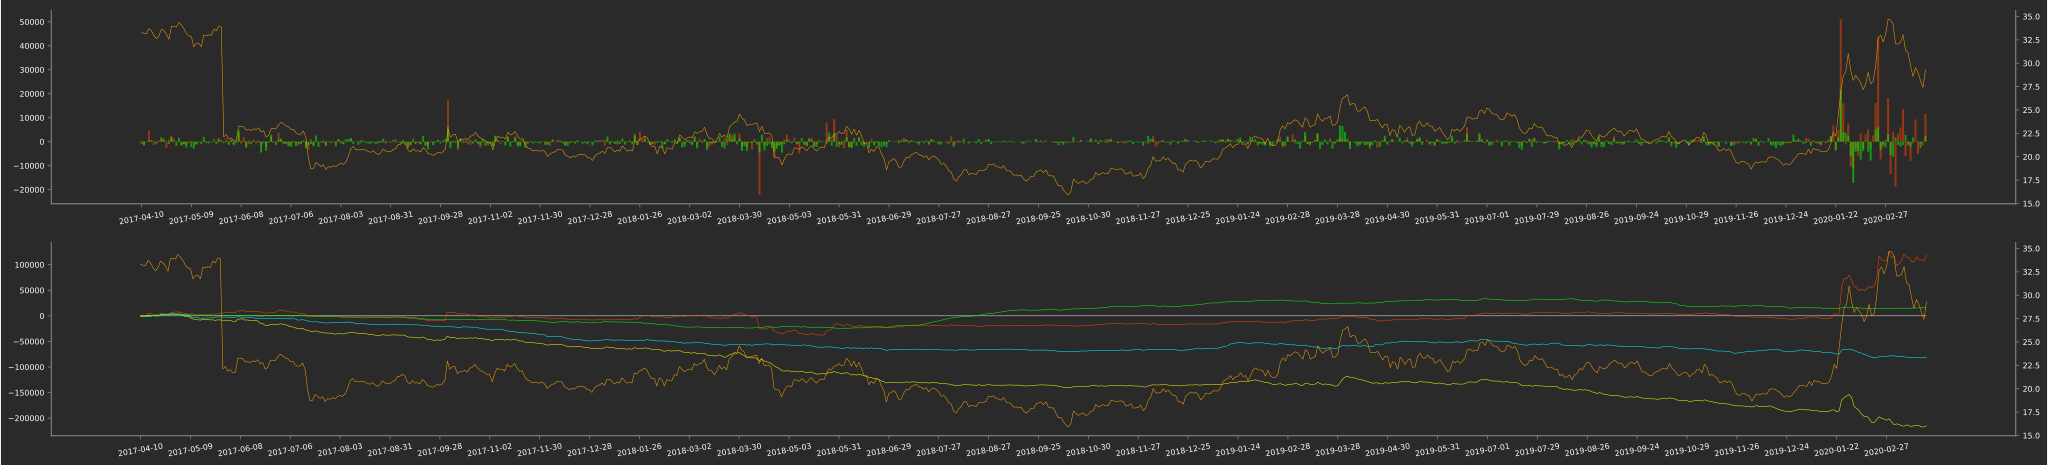

In [87]:
sto_id = random.sample(all_sto_ids, 1)[0]
# sto_id = '600712'
sto_id = '002223'

display_sto_info(sto_id)

delta = 15
daily_count = int(240/delta)
tmp_df = BaosAgent.read_freq_df(delta, sto_id)
# tmp_df = DataUtil.add_rt_data(sto_id, tmp_df, delta, JQDataUtil.get_end_ts(delta))
tmp_df['k_01d'], tmp_df['d_01d'] = talib.STOCH(tmp_df.high, tmp_df.low, tmp_df.close, fastk_period=9*daily_count,   slowk_period=3*daily_count,   slowd_period=3*daily_count)
tmp_df['k_05d'], tmp_df['d_05d'] = talib.STOCH(tmp_df.high, tmp_df.low, tmp_df.close, fastk_period=9*daily_count*5, slowk_period=3*daily_count*5, slowd_period=3*daily_count*5)
tmp_df = tmp_df.dropna()
tmp_df = tmp_df[-daily_count*240*3:]
tmp_df = tmp_df.reset_index(drop=True)
plot_ta(tmp_df)

bg_date = tmp_df.iloc[0].date
mf_df = prepare_mf_data(sto_id, 240 * 3)
mf_df = mf_df[mf_df.closes > 0]
mf_df = mf_df[mf_df.dates >= bg_date]
plot_mf(sto_id, mf_df)


In [ ]:
fig = plt.figure(figsize=(len(tmp_df)/128, 8))
fig.patch.set_facecolor('#2A2A2A')
xaxis_idxes = tmp_df.time.str[:4] + '-' + tmp_df.time.str[4:6] + '-' + tmp_df.time.str[6:8] + ' ' + tmp_df.time.str[8:10] + ':' + tmp_df.time.str[10:12]
x_axis_slice = slice(0, -1, daily_count * 5 * 4)

ax = plt.subplot(1,1,1)
PlotTool.custom_ax(ax)
ax.plot(xaxis_idxes, tmp_df.macdhist_01d, color='orange')
ax.hlines(0, xmin=min(tmp_df.index), xmax=max(tmp_df.index), color='yellow', lw=.3)
PlotTool.custom_axticks(ax, xaxis_idxes, x_axis_slice)

ax2 = ax.twinx()
PlotTool.custom_ax(ax2)
ax2.plot(xaxis_idxes, np.gradient(tmp_df.macdhist_01d))
PlotTool.custom_axticks(ax2, xaxis_idxes, x_axis_slice)
align_yaxis(ax, ax2, 0)

plt.show()

In [ ]:

plt.plot(tmp_df.index, tmp_df.macdhist_01d)
plt.plot(tmp_df.index, np.gradient(tmp_df.macdhist_01d))

In [ ]:
tmp_df.macdhist_05d - 2*tmp_df.macdhist_05d.shift(1) + tmp_df.macdhist_05d.shift(2)

In [ ]:
%%time

delta = 15
daily_count = int(240/delta)
tmp_sto_id = random.sample(obs_sto_ids,1)[0]


tmp_df = BaosAgent.read_freq_df(delta, tmp_sto_id)
tmp_df = FeatureTool.add_kds_indicators(tmp_df, daily_count)
tmp_df = tmp_df.dropna()
tmp_df = tmp_df.reset_index(drop=True)

cond_k_up = (tmp_df.k_05d > tmp_df.k_05d.shift(1))
cond_k_up = (tmp_df.k_06d > tmp_df.k_06d.shift(1)) & cond_k_up
cond_k_up = (tmp_df.k_07d > tmp_df.k_07d.shift(1)) & cond_k_up
cond_k_up = (tmp_df.k_08d > tmp_df.k_08d.shift(1)) & cond_k_up
cond_k_up = (tmp_df.k_09d > tmp_df.k_09d.shift(1)) & cond_k_up
cond_k_up = (tmp_df.k_10d > tmp_df.k_10d.shift(1)) & cond_k_up
cond_k_up = (tmp_df.k_11d > tmp_df.k_11d.shift(1)) & cond_k_up
cond_k_up = (tmp_df.k_12d > tmp_df.k_12d.shift(1)) & cond_k_up
cond_k_up = (tmp_df.k_13d > tmp_df.k_13d.shift(1)) & cond_k_up
cond_k_up = (tmp_df.k_14d > tmp_df.k_14d.shift(1)) & cond_k_up
cond_k_up = (tmp_df.k_15d > tmp_df.k_15d.shift(1)) & cond_k_up
cond_k_up = (tmp_df.k_16d > tmp_df.k_16d.shift(1)) & cond_k_up
cond_k_up = (tmp_df.k_17d > tmp_df.k_17d.shift(1)) & cond_k_up
cond_k_up = (tmp_df.k_18d > tmp_df.k_18d.shift(1)) & cond_k_up
cond_k_up = (tmp_df.k_19d > tmp_df.k_19d.shift(1)) & cond_k_up
cond_k_up = (tmp_df.k_20d > tmp_df.k_20d.shift(1)) & cond_k_up
cond = (tmp_df.k_01d > tmp_df.k_01d.shift(1)) & (tmp_df.k_01d.shift(2) > tmp_df.k_01d.shift(1)) & cond_k_up
cps    = tmp_df.iloc[tmp_df[cond].index].close
k01ds = tmp_df.iloc[tmp_df[cond].index].k_01d
df = pd.concat([cps, k01ds], axis=1)
target_idxes = df[(df.close < df.close.shift(1)) & (df.k_01d > df.k_01d.shift(1))].index
for target_idx in target_idxes:
    cp = tmp_df.iloc[target_idx].close
    max_cp = np.max(tmp_df.high.iloc[target_idx + 1:target_idx + daily_count * 5 * 4])
    min_cp = np.min(tmp_df.low.iloc[target_idx + 1:target_idx + daily_count * 5 * 4])
    max_cr = (max_cp - cp) / cp
    min_cr = (min_cp - cp) / cp
    print('{} {:>7.2%} {:>7.2%}'.format(tmp_sto_id, max_cr, min_cr))


In [ ]:
def get_sub_results(sub_sto_ids):
    sub_max_cr = []
    sub_min_cr = []
    for tmp_sto_id in tqdm(sub_sto_ids):
        tmp_df = BaosAgent.read_freq_df(delta, tmp_sto_id)
        tmp_df = FeatureTool.add_kds_indicators(tmp_df, daily_count)
        tmp_df = tmp_df.dropna()
        tmp_df = tmp_df.reset_index(drop=True)

        cond_k_up = (tmp_df.k_05d > tmp_df.k_05d.shift(1))
        cond_k_up = (tmp_df.k_06d > tmp_df.k_06d.shift(1)) & cond_k_up
        cond_k_up = (tmp_df.k_07d > tmp_df.k_07d.shift(1)) & cond_k_up
        cond_k_up = (tmp_df.k_08d > tmp_df.k_08d.shift(1)) & cond_k_up
        cond_k_up = (tmp_df.k_09d > tmp_df.k_09d.shift(1)) & cond_k_up
        cond_k_up = (tmp_df.k_10d > tmp_df.k_10d.shift(1)) & cond_k_up
        cond_k_up = (tmp_df.k_11d > tmp_df.k_11d.shift(1)) & cond_k_up
        cond_k_up = (tmp_df.k_12d > tmp_df.k_12d.shift(1)) & cond_k_up
        cond_k_up = (tmp_df.k_13d > tmp_df.k_13d.shift(1)) & cond_k_up
        cond_k_up = (tmp_df.k_14d > tmp_df.k_14d.shift(1)) & cond_k_up
        cond_k_up = (tmp_df.k_15d > tmp_df.k_15d.shift(1)) & cond_k_up
        cond_k_up = (tmp_df.k_16d > tmp_df.k_16d.shift(1)) & cond_k_up
        cond_k_up = (tmp_df.k_17d > tmp_df.k_17d.shift(1)) & cond_k_up
        cond_k_up = (tmp_df.k_18d > tmp_df.k_18d.shift(1)) & cond_k_up
        cond_k_up = (tmp_df.k_19d > tmp_df.k_19d.shift(1)) & cond_k_up
        cond_k_up = (tmp_df.k_20d > tmp_df.k_20d.shift(1)) & cond_k_up
        cond = (tmp_df.k_01d > tmp_df.k_01d.shift(1)) & (tmp_df.k_01d.shift(2) > tmp_df.k_01d.shift(1)) & cond_k_up
        cps   = tmp_df.iloc[tmp_df[cond].index].close
        k01ds = tmp_df.iloc[tmp_df[cond].index].k_01d
        df = pd.concat([cps, k01ds], axis=1)
        target_idxes = df[(df.close < df.close.shift(1)) & (df.k_01d > df.k_01d.shift(1))].index
        for target_idx in target_idxes:
            cp = tmp_df.iloc[target_idx].close
            max_cp = np.max(tmp_df.high.iloc[target_idx + 1:target_idx + daily_count * 5 * 4])
            min_cp = np.min(tmp_df.low.iloc[target_idx + 1:target_idx + daily_count * 5 * 4])
            max_cr = (max_cp - cp) / cp
            min_cr = (min_cp - cp) / cp
            # print('{} {:>7.2%} {:>7.2%}'.format(tmp_sto_id, max_cr, min_cr))
            sub_max_cr.append(max_cr)
            sub_min_cr.append(min_cr)
    return sub_max_cr, sub_min_cr

In [ ]:
delta = 15
daily_count = int(240/delta)

NUM_PROCESS = 3
size = math.ceil(len(obs_sto_ids) / NUM_PROCESS)
sub_seqs = []
for proc_idx in range(NUM_PROCESS):
    start_idx = size * proc_idx
    stop_idx = size * (proc_idx + 1)
    sub_seq = obs_sto_ids[start_idx:stop_idx]
    sub_seqs.append(sub_seq)

with Pool(NUM_PROCESS) as pool:
    rlts = pool.map(get_sub_results, sub_seqs)


In [ ]:
all_max_cr, all_min_cr = [], []
for rlt in rlts:
    sub_max_cr, sub_min_cr = rlt
    print(len(sub_max_cr), len(sub_min_cr))
    all_max_cr.extend(sub_max_cr), 
    all_min_cr.extend(sub_min_cr)

In [ ]:
crs = []
for idx in range(len(all_max_cr)):
    sub_max_cr, sub_min_cr = rlt
    cr = [all_max_cr[idx], all_min_cr[idx]]
    crs.append(cr)

In [ ]:
cr_df = pd.DataFrame(data=crs, columns=['max_cr', 'min_cr'])

In [ ]:
cr_df.max_cr.hist(bins=1000, figsize=(36, 5))

In [ ]:
cr_df.min_cr.hist(bins=1000, figsize=(36, 5))

In [ ]:
def find_alternatives(sub_sto_ids):
    sub_alternative_sto_ids = {}
    for sto_id in tqdm(sub_sto_ids):
        tmp_df = BaosAgent.read_freq_df(delta, sto_id)
#         tmp_df = tmp_df.iloc[-11198 - daily_count * 5 * 12:]
#         tmp_df = tmp_df.reset_index(drop=True)
        tmp_df = FeatureTool.add_kds_indicators(tmp_df, daily_count)
        tmp_df = FeatureTool.add_macd_indicators(tmp_df, daily_count)
        tmp_df = tmp_df.dropna()
        tmp_df = tmp_df.reset_index(drop=True)
        if len(tmp_df) < daily_count * 5 * 5:
            continue

        start_obs_idx = tmp_df.index[-daily_count]
        stop_obs_idx = tmp_df.index[-1]

        cond_ksum_cross_50 = (tmp_df.k_sum.shift(1) < 50) & (tmp_df.k_sum > 50)
        cond_ksum_cross_50_idxes = tmp_df[cond_ksum_cross_50].index
        cond_ksum_cross_50_alternative_ts = []
        for idx in cond_ksum_cross_50_idxes:
            if idx >= start_obs_idx and idx <=stop_obs_idx:
                cond_ksum_cross_50_alternative_ts.append(tmp_df.iloc[idx].time)

        cond_macdhistsum_cross_0 = (tmp_df.macdhist_sum.shift(1) < 0) & (tmp_df.macdhist_sum > 0)
        cond_macdhistsum_cross_0_idxes = tmp_df[cond_macdhistsum_cross_0].index
        cond_macdhistsum_cross_0_alternative_ts = []
        for idx in cond_macdhistsum_cross_0_idxes:
            if idx >= start_obs_idx and idx <= stop_obs_idx:
                cond_macdhistsum_cross_0_alternative_ts.append(tmp_df.iloc[idx].time)
        
        if len(cond_macdhistsum_cross_0_alternative_ts) > 0 or len(cond_macdhistsum_cross_0_alternative_ts) > 0:
            print(sto_id)
            
            target_idxes = tmp_df[tmp_df.time.isin(cond_ksum_cross_50_alternative_ts)].index
            for target_idx in target_idxes:
                print(tmp_df.iloc[target_idx-1].k_sum, tmp_df.iloc[target_idx].k_sum, tmp_df.iloc[target_idx].time)

            target_idxes = tmp_df[tmp_df.time.isin(cond_macdhistsum_cross_0_alternative_ts)].index
            for target_idx in target_idxes:
                print(tmp_df.iloc[target_idx-1].macdhist_sum, tmp_df.iloc[target_idx].macdhist_sum, tmp_df.iloc[target_idx].time)

            sub_alternative_sto_ids[sto_id] = {'k_sum_cross_50':cond_ksum_cross_50_alternative_ts, 'macdhist_sum_cross_0':cond_macdhistsum_cross_0_alternative_ts}
        
    return sub_alternative_sto_ids

def find_alternatives_callback(rlts):
    alternative_sto_infos = {}
    for rlt in rlts:
        for key, value in rlt.items():
            alternative_sto_infos[key] = value
    return alternative_sto_infos

delta = 15
daily_count = int(240/delta)
all_sto_ids = get_freq_file_sto_ids(delta)

NUM_PROCESS = 5
size = math.ceil(len(obs_sto_ids) / NUM_PROCESS)
sub_seqs = []
for proc_idx in range(NUM_PROCESS):
    start_idx = size * proc_idx
    stop_idx = size * (proc_idx + 1)
    sub_seq = obs_sto_ids[start_idx:stop_idx]
    sub_seqs.append(sub_seq)

with Pool(NUM_PROCESS) as pool:
    rlts = pool.map(find_alternatives, sub_seqs)
    alternative_sto_infos = find_alternatives_callback(rlts)
    print(alternative_sto_infos)

In [ ]:
def plot_obs_df(tmp_df):
    fig = plt.figure(figsize=(len(tmp_df)/128, 20))
    fig.patch.set_facecolor('#2A2A2A')
    xaxis_idxes = tmp_df.time.str[:4] + '-' + tmp_df.time.str[4:6] + '-' + tmp_df.time.str[6:8] + ' ' + tmp_df.time.str[8:10] + ':' + tmp_df.time.str[10:12]
    x_axis_slice = slice(0, -1, daily_count * 5 * 4)

    ############## subplot 1 ##############
#     ax = plt.subplot(5,1,1)
#     PlotTool.custom_ax(ax)
#     for col in tmp_df.columns:
#         if col.startswith('vol_1t_sum_last_'):
#             ax.plot(xaxis_idxes, tmp_df[col], lw=.2, color='cyan')
#     PlotTool.custom_axticks(ax, xaxis_idxes, x_axis_slice)

#     ax2 = ax.twinx()
#     PlotTool.custom_ax(ax2)
#     ax2.plot(xaxis_idxes, tmp_df.close, color='orange', lw=.5)
#     for col in tmp_df.columns:
#         if col.startswith('closema_'):
#             ax2.plot(xaxis_idxes, tmp_df[col], lw=.2, color='orange')
#     # minp, maxp = np.min(tmp_df.close), np.max(tmp_df.close)
#     # for cond_idx in tmp_df[cond_vup_pup].index:
#     #     ax2.vlines(tmp_df.index[cond_vup_pup], minp, maxp, lw=.5, color='orange')
#     # for cond_idx in tmp_df[cond_vup_pdn].index:
#     #     ax2.vlines(tmp_df.index[cond_vup_pdn], minp, maxp, lw=.5, color='lime')
#     PlotTool.custom_axticks(ax2, xaxis_idxes, x_axis_slice)

    ############## subplot 2 ##############
#     ax = plt.subplot(5,1,2)
#     PlotTool.custom_ax(ax)
#     cols = []
#     for col in tmp_df.columns:
#         if col.startswith("closema_"):
#             cols.append(col)
#     tmp_df['close_ma_idx'] = 0
#     first_idx = 0
#     for idx in range(first_idx, len(cols) - 1):
#         tmp_df.loc[tmp_df[cols[idx]] > tmp_df[cols[idx+1]], 'close_ma_idx'] += 1
#     ax.plot(xaxis_idxes, tmp_df.close_ma_idx, lw=.5, color='gold')

#     cols = []
#     for col in tmp_df.columns:
#         if col.startswith("volma_"):
#             cols.append(col)
#     tmp_df['vol_ma_idx'] = 0
#     first_idx = 0
#     for idx in range(first_idx, len(cols) - 1):
#         tmp_df.loc[tmp_df[cols[idx]] > tmp_df[cols[idx+1]], 'vol_ma_idx'] += 1
#     ax.plot(xaxis_idxes, tmp_df.vol_ma_idx, lw=.5, color='cyan')
#     PlotTool.custom_axticks(ax, xaxis_idxes, x_axis_slice)

#     ax2 = ax.twinx()
#     PlotTool.custom_ax(ax2)
#     ax2.plot(xaxis_idxes, tmp_df.close, color='orange', lw=.5)
#     for col in tmp_df.columns:
#         if col.startswith('closema_'):
#             ax2.plot(xaxis_idxes, tmp_df[col], lw=.2, color='orange')
#     PlotTool.custom_axticks(ax2, xaxis_idxes, x_axis_slice)

    ############## subplot 3 ##############
    ax = plt.subplot(6,1,3)
    PlotTool.custom_ax(ax)
    for col in tmp_df.columns:
        if col.startswith('volma_'):
            ax.plot(xaxis_idxes, tmp_df[col], lw=.1, color='cyan')
    PlotTool.custom_axticks(ax, xaxis_idxes, x_axis_slice)
    ax2 = ax.twinx()
    PlotTool.custom_ax(ax2)
    ax2.plot(xaxis_idxes, tmp_df.close, color='orange', lw=.5)
    for col in tmp_df.columns:
        if col.startswith('closema_'):
            ax2.plot(xaxis_idxes, tmp_df[col], lw=.2, color='orange')
    PlotTool.custom_axticks(ax2, xaxis_idxes, x_axis_slice)

    ############## subplot 4 ##############
    ax = plt.subplot(6,1,4)
    PlotTool.custom_ax(ax)
    for col in tmp_df.columns:
        if col.startswith('k_') and col.endswith('d'):
            ax.plot(xaxis_idxes, tmp_df[col], lw=.3, color='cyan')
    ax.plot(xaxis_idxes, tmp_df['k_sum'], lw=1, color='cyan')
    ax.hlines(80, xmin=min(xaxis_idxes), xmax=max(xaxis_idxes), color='w', lw=.2)
    ax.hlines(50, xmin=min(xaxis_idxes), xmax=max(xaxis_idxes), color='w', lw=.2)
    ax.hlines(20, xmin=min(xaxis_idxes), xmax=max(xaxis_idxes), color='w', lw=.2)
    PlotTool.custom_axticks(ax, xaxis_idxes, x_axis_slice)
    ax2 = ax.twinx()
    PlotTool.custom_ax(ax2)
    ax2.plot(xaxis_idxes, tmp_df.close, color='orange', lw=.5)
#     for col in tmp_df.columns:
#         if col.startswith('closema_'):
#             ax2.plot(xaxis_idxes, tmp_df[col], lw=.2, color='orange')
    
    cond_ksum_cross_50_alternative_ts = alternative_sto_infos[tmp_sto_id]['k_sum_cross_50']
    target_idxes = tmp_df[tmp_df.time.isin(cond_ksum_cross_50_alternative_ts)].index
    for target_idx in target_idxes:
        ax2.vlines(xaxis_idxes[target_idx], np.min(tmp_df.close), np.max(tmp_df.close), lw=.2, color='yellow')
    PlotTool.custom_axticks(ax2, xaxis_idxes, x_axis_slice)

    ############## subplot 5 ##############
    ax = plt.subplot(6,1,5)
    PlotTool.custom_ax(ax)
    for col in tmp_df.columns:
        if col.startswith('macdhist_') and col.endswith('d'):
            ax.plot(xaxis_idxes, tmp_df[col], lw=.3, color='cyan')
    ax.plot(xaxis_idxes, tmp_df['macdhist_sum'], lw=1, color='cyan')
    ax.hlines(0, xmin=min(xaxis_idxes), xmax=max(xaxis_idxes), color='w', lw=.2)
    PlotTool.custom_axticks(ax, xaxis_idxes, x_axis_slice)
    ax2 = ax.twinx()
    PlotTool.custom_ax(ax2)
    ax2.plot(xaxis_idxes, tmp_df.close, color='orange', lw=.5)
#     for col in tmp_df.columns:
#         if col.startswith('closema_'):
#             ax2.plot(xaxis_idxes, tmp_df[col], lw=.2, color='orange')

    cond_macdhistsum_cross_0_alternative_ts = alternative_sto_infos[tmp_sto_id]['macdhist_sum_cross_0']
    target_idxes = tmp_df[tmp_df.time.isin(cond_macdhistsum_cross_0_alternative_ts)].index
    for target_idx in target_idxes:
        ax2.vlines(xaxis_idxes[target_idx], np.min(tmp_df.close), np.max(tmp_df.close), lw=.2, color='yellow')
    PlotTool.custom_axticks(ax2, xaxis_idxes, x_axis_slice)
    
    ############## subplot 6 ##############
    ax = plt.subplot(6,1,6)
    PlotTool.custom_ax(ax)
#     for col in tmp_df.columns:
#         if col.startswith('mfi_') and col.endswith('d'):
#             ax.plot(xaxis_idxes, tmp_df[col], lw=.2, color='cyan')
#     ax.plot(xaxis_idxes, tmp_df['mfi_01d'], lw=.1, color='cyan')

#     ax.fill_between(xaxis_idxes, tmp_df.mfi_05d, 50, where=tmp_df.mfi_05d > 50, facecolor='orange', alpha=0.3)
#     ax.fill_between(xaxis_idxes, 50, tmp_df.mfi_05d, where=tmp_df.mfi_05d < 50, facecolor='lime',   alpha=0.3)

    ax.fill_between(xaxis_idxes, tmp_df.mfi_01d, 50, where=tmp_df.mfi_01d > 50, facecolor='orange', alpha=0.3)
    ax.fill_between(xaxis_idxes, 50, tmp_df.mfi_01d, where=tmp_df.mfi_01d < 50, facecolor='lime',   alpha=0.3)
    ax.hlines(80, xmin=min(xaxis_idxes), xmax=max(xaxis_idxes), color='w', lw=.3)
    ax.hlines(50, xmin=min(xaxis_idxes), xmax=max(xaxis_idxes), color='w', lw=.3)
    ax.hlines(20, xmin=min(xaxis_idxes), xmax=max(xaxis_idxes), color='w', lw=.3)
    
#     ax.hlines(50, xmin=min(xaxis_idxes), xmax=max(xaxis_idxes), color='w', lw=.1)
    PlotTool.custom_axticks(ax, xaxis_idxes, x_axis_slice)
    ax2 = ax.twinx()
    PlotTool.custom_ax(ax2)
    ax2.plot(xaxis_idxes, tmp_df.close, color='orange', lw=.5)
#     for col in tmp_df.columns:
#         if col.startswith('closema_'):
#             ax2.plot(xaxis_idxes, tmp_df[col], lw=.2, color='orange')
    PlotTool.custom_axticks(ax2, xaxis_idxes, x_axis_slice)

    plt.show()

In [ ]:
delta = 15
daily_count = int(240/delta)
tmp_sto_id = random.sample(alternative_sto_infos.keys(),1)[0]
# tmp_sto_id = '300199'
for tmp_sto_id in alternative_sto_infos.keys():
    print(alternative_sto_infos[tmp_sto_id])

    tmp_df = BaosAgent.read_freq_df(delta, tmp_sto_id)
    begin_date = tmp_df.iloc[0].date
    tmp_df = FeatureTool.add_close_vol_ma(tmp_df, daily_count)
    tmp_df = FeatureTool.add_mfi_indicators(tmp_df, daily_count)
    tmp_df = FeatureTool.add_kds_indicators(tmp_df, daily_count)
    tmp_df = FeatureTool.add_macd_indicators(tmp_df, daily_count)
    tmp_df = tmp_df.iloc[-daily_count*5*60:]
    tmp_df = tmp_df.dropna()
    tmp_df = tmp_df.reset_index(drop=True)

    bs.login()
    bs_sto_id = BaosAgent.get_baostock_sto_id(tmp_sto_id)
    sto_name = bs.query_stock_basic(code=bs_sto_id).get_row_data()[1]
    print(tmp_sto_id, sto_name, begin_date, tmp_df.iloc[0].date, tmp_df.iloc[-1].date, tmp_df.index[-daily_count*5*4])
    bs.logout()

    cond_ksum_cross_50_alternative_ts = alternative_sto_infos[tmp_sto_id]['k_sum_cross_50']
    target_idxes = tmp_df[tmp_df.time.isin(cond_ksum_cross_50_alternative_ts)].index
    for target_idx in target_idxes:
        print(tmp_df.iloc[target_idx-1].k_sum, tmp_df.iloc[target_idx].k_sum)

    cond_macdhistsum_cross_0_alternative_ts = alternative_sto_infos[tmp_sto_id]['macdhist_sum_cross_0']
    target_idxes = tmp_df[tmp_df.time.isin(cond_macdhistsum_cross_0_alternative_ts)].index
    for target_idx in target_idxes:
        print(tmp_df.iloc[target_idx-1].macdhist_sum, tmp_df.iloc[target_idx].macdhist_sum)

    plot_obs_df(tmp_df)

In [ ]:
all_crabove20in1week_df = pd.read_csv('all_crabove20in1week_df.csv', dtype={'sto_id':str, 'ts':str})

In [ ]:
first_idx = 0
while first_idx < len(cols):
    for idx in range(first_idx, len(cols) - 1):
        print((idx, idx + 1), end=',')
    print()
    first_idx += 1

In [ ]:
delta = 15
daily_count = int(240/delta)
hourly_count = int(60/delta)
# sto_ids = get_freq_file_sto_ids(delta)
# tmp_sto_id = random.sample(sto_ids, 1)[0]

tmp_sto_id = all_crabove20in1week_df.sample(1).sto_id.values[0]
crabove20in1week_df = all_crabove20in1week_df[all_crabove20in1week_df.sto_id == tmp_sto_id]
match_ts = crabove20in1week_df.ts.values.tolist()


# random_target = target_df.sample(1).iloc[0]
# tmp_sto_id = random_target.sto_id
# target_ts = random_target.ts

print(tmp_sto_id)
### Prepare sto data.
tmp_df = BaosAgent.read_freq_df(delta, tmp_sto_id)
l1 = len(tmp_df)
### Add TA features.
t1 = datetime.now()
tmp_df = FeatureTool.add_volma_indicators(tmp_df, daily_count)
tmp_df = FeatureTool.add_closema_indicators(tmp_df, daily_count)
tmp_df = FeatureTool.add_macd_indicators(tmp_df, daily_count)
tmp_df = FeatureTool.add_kds_indicators(tmp_df, daily_count)

# tmp_df['corr_close_vol'] = tmp_df.volume.rolling(hourly_count).corr(tmp_df.close)
# tmp_df['volume_slope']   = tmp_df.volume.rolling(hourly_count).apply(compute_slopes, raw=True)
# tmp_df['close_slope']    = tmp_df.close.rolling(hourly_count).apply(compute_slopes, raw=True)

### Clean up data.
tmp_df = tmp_df.dropna()
print(datetime.now() - t1)

# close_slope_factor = math.floor(1 / max(abs(np.max(tmp_df.close_slope)), abs(np.min(tmp_df.close_slope))))
# tmp_df.close_slope = tmp_df.close_slope * close_slope_factor

# tmp_df = tmp_df.iloc[-daily_count * 5 * 4:]
tmp_df = tmp_df.reset_index(drop=True)

### Plot figure.
if len(tmp_df) > 0:
    target_idxes = tmp_df[tmp_df.time.isin(match_ts)].index
    print(target_idxes.values)
#     target_idxes = tmp_df[tmp_df.time == target_ts].index
#     print(tmp_df.macdhist_avg_w.iloc[target_idxes[0]-2], tmp_df.macdhist_avg_w.iloc[target_idxes[0]-1], tmp_df.macdhist_avg_w.iloc[target_idxes[0]])
#     print(tmp_df.macdhist_avg_d.iloc[target_idxes[0]-2], tmp_df.macdhist_avg_d.iloc[target_idxes[0]-1], tmp_df.macdhist_avg_d.iloc[target_idxes[0]])
    PlotTool.plot_figure(tmp_df, daily_count, target_idxes, False)

In [ ]:
%run plotutils.py

In [ ]:
def find_macd_avg_dw_up(sub_sto_ids, target_idx):
    match_infos = []
    for tmp_sto_id in tqdm(sub_sto_ids):
        tmp_df = BaosAgent.read_freq_df(delta, tmp_sto_id)
        minimum_size = 11198 + daily_count * 5 * 6
        if l1 < minimum_size:
            continue
        tmp_df = tmp_df.iloc[-minimum_size:].copy()
        factor_4w = daily_count * 20
        factor_3w = daily_count * 15
        factor_2w = daily_count * 10
        factor_5d = daily_count * 5
        factor_4d = daily_count * 4
        factor_3d = daily_count * 3
        factor_2d = daily_count * 2
        factor_1d = daily_count * 1
        tmp_df['macd_4w'], tmp_df['macdsignal_4w'], tmp_df['macdhist_4w'] = talib.MACD(tmp_df.close, fastperiod=12*factor_4w, slowperiod=26*factor_4w, signalperiod=9*factor_4w)
        tmp_df['macd_3w'], tmp_df['macdsignal_3w'], tmp_df['macdhist_3w'] = talib.MACD(tmp_df.close, fastperiod=12*factor_3w, slowperiod=26*factor_3w, signalperiod=9*factor_3w)
        tmp_df['macd_2w'], tmp_df['macdsignal_2w'], tmp_df['macdhist_2w'] = talib.MACD(tmp_df.close, fastperiod=12*factor_2w, slowperiod=26*factor_2w, signalperiod=9*factor_2w)
        tmp_df['macd_1w'], tmp_df['macdsignal_1w'], tmp_df['macdhist_1w'] = talib.MACD(tmp_df.close, fastperiod=12*factor_5d, slowperiod=26*factor_5d, signalperiod=9*factor_5d)
        tmp_df['macd_4d'], tmp_df['macdsignal_4d'], tmp_df['macdhist_4d'] = talib.MACD(tmp_df.close, fastperiod=12*factor_4d, slowperiod=26*factor_4d, signalperiod=9*factor_4d)
        tmp_df['macd_3d'], tmp_df['macdsignal_3d'], tmp_df['macdhist_3d'] = talib.MACD(tmp_df.close, fastperiod=12*factor_3d, slowperiod=26*factor_3d, signalperiod=9*factor_3d)
        tmp_df['macd_2d'], tmp_df['macdsignal_2d'], tmp_df['macdhist_2d'] = talib.MACD(tmp_df.close, fastperiod=12*factor_2d, slowperiod=26*factor_2d, signalperiod=9*factor_2d)
        tmp_df['macd_1d'], tmp_df['macdsignal_1d'], tmp_df['macdhist_1d'] = talib.MACD(tmp_df.close, fastperiod=12*factor_1d, slowperiod=26*factor_1d, signalperiod=9*factor_1d)
        tmp_df['macdhist_avg_w'] = (tmp_df.macdhist_1w + tmp_df.macdhist_2w + tmp_df.macdhist_3w + tmp_df.macdhist_4w) / 4
        tmp_df['macdhist_avg_d'] = (tmp_df.macdhist_1d + tmp_df.macdhist_2d + tmp_df.macdhist_3d + tmp_df.macdhist_4d) / 4
        tmp_df = tmp_df.dropna()
        tmp_df = tmp_df.reset_index(drop=True)
        if len(tmp_df) < abs(target_idx):
            continue
        cond_macd_avg_dw_up = (tmp_df.macdhist_avg_w > tmp_df.macdhist_avg_w.shift(1))
        cond_macd_avg_dw_up = (tmp_df.macdhist_avg_d > tmp_df.macdhist_avg_d.shift(1)) & cond_macd_avg_dw_up
        if not cond_macd_avg_dw_up.iloc[target_idx-1] and cond_macd_avg_dw_up.iloc[target_idx]:
            print(tmp_df.macdhist_avg_w.iloc[target_idx-2], tmp_df.macdhist_avg_w.iloc[target_idx-1], tmp_df.macdhist_avg_w.iloc[target_idx])
            print(tmp_df.macdhist_avg_d.iloc[target_idx-2], tmp_df.macdhist_avg_d.iloc[target_idx-1], tmp_df.macdhist_avg_d.iloc[target_idx])
            print(tmp_sto_id, tmp_df.iloc[target_idx].time, cond_macd_avg_dw_up.iloc[target_idx-1], cond_macd_avg_dw_up.iloc[target_idx])
            match_infos.append([tmp_sto_id, tmp_df.iloc[target_idx].time])
    return match_infos

def find_macd_dwlong_callback(rlts):
    all_match_infos = []
    for rlt in rlts:
        all_match_infos.extend(rlt)
    print(len(all_match_infos))
    target_df = pd.DataFrame(columns=['sto_id', 'ts'], data=all_match_infos)
    target_df = target_df.sort_values(by=['sto_id'])
    target_df = target_df.reset_index(drop=True)
    return target_df

delta = 15
daily_count = int(240/delta)
sto_ids = get_freq_file_sto_ids(delta)
# sto_ids = target_df.sto_id.values
NUM_PROCESS = 6
size = math.ceil(len(sto_ids) / NUM_PROCESS)
sub_seqs = []
for proc_idx in range(NUM_PROCESS):
    start_idx = size * proc_idx
    stop_idx = size * (proc_idx + 1)
    sub_seq = sto_ids[start_idx:stop_idx]
    sub_seqs.append(sub_seq)

# for obs_idx in range(-12, 0, 1):
obs_idx = -88
print(obs_idx)
with Pool(NUM_PROCESS) as pool:
    rlts = pool.map(partial(find_macd_avg_dw_up, target_idx=obs_idx), sub_seqs)
    target_df = find_macd_dwlong_callback(rlts)
#     if len(target_df) > 0:
#         fn = target_df.iloc[0].ts[4:] + '.txt'
#         sto_id_df = target_df[['sto_id']]
#         sto_id_df.to_csv('/Users/allan/Downloads/VMShare/obs/'+fn, header=False, index=False)

In [ ]:
def find_macd_dwlong(sub_sto_ids, target_idx, jq_end_ts):
    if enable_rt:
        jq.auth('15808061188', 'allan2jq')
        time.sleep(3)
    match_infos = []
    minimum_size = 11198 + daily_count * 12 * 5
    for tmp_sto_id in tqdm(sub_sto_ids):
        tmp_df = BaosAgent.read_freq_df(delta, tmp_sto_id)
        if len(tmp_df) < minimum_size or tmp_df.iloc[target_idx].close > 20:
            continue
        if enable_rt:
            # print('get realtime data from JQData ...')
            tmp_df = DataUtil.add_rt_data(tmp_sto_id, tmp_df, delta, jq_end_ts)
            # tmp_df = DataUtil.add_rt_data(tmp_sto_id, tmp_df, delta, '2020-02-24 11:30:00')
            # print('get realtime data from JQData accomplished.')

        tmp_df = tmp_df[-minimum_size:].copy()
        tmp_df = tmp_df.reset_index(drop=True)

        tmp_df = FeatureTool.add_macd_indicators(tmp_df, daily_count)
        tmp_df['k_1t'], tmp_df['d_1t'] = talib.STOCH(tmp_df.high, tmp_df.low, tmp_df.close, fastk_period=9, slowk_period=3, slowd_period=3)
        tmp_df = tmp_df.dropna()
        tmp_df = tmp_df.reset_index(drop=True)
        
        cond_macd_dlong = (tmp_df.macdhist_1d > tmp_df.macdhist_1d.shift(1)) & (tmp_df.macdhist_2d > tmp_df.macdhist_2d.shift(1)) & (tmp_df.macdhist_3d > tmp_df.macdhist_3d.shift(1)) & (tmp_df.macdhist_4d > tmp_df.macdhist_4d.shift(1))
        cond_macd_wlong = (tmp_df.macdhist_1w > tmp_df.macdhist_1w.shift(1)) & (tmp_df.macdhist_2w > tmp_df.macdhist_2w.shift(1)) & (tmp_df.macdhist_3w > tmp_df.macdhist_3w.shift(1)) & (tmp_df.macdhist_4w > tmp_df.macdhist_4w.shift(1))
        cond_macd_1t1h_increase = (tmp_df.macdhist_1t > tmp_df.macdhist_1t.shift(1)) & (tmp_df.macdhist_1h > tmp_df.macdhist_1h.shift(1))
        cond = cond_macd_dlong & cond_macd_wlong & cond_macd_1t1h_increase
        cur_idx = tmp_df.index[target_idx]
        
        tmp_df.loc[tmp_df.volume==0, 'volume'] = 5000
        tmp_df['vol_log_ma_1h'] = talib.MA(np.log(tmp_df.volume), timeperiod=4)
        tmp_df['closema_1h'] = talib.MA(tmp_df.close, timeperiod=4)
        cur_vpcorr = tmp_df.vol_log_ma_1h.iloc[cur_idx-3:cur_idx+1].corr(tmp_df.closema_1h.iloc[cur_idx-3:cur_idx+1])
        volume_slope, intercept, r_value, p_value, std_err = stats.linregress(range(4), tmp_df.vol_log_ma_1h.iloc[cur_idx-3:cur_idx+1])
        close_slope,  intercept, r_value, p_value, std_err = stats.linregress(range(4), tmp_df.closema_1h.iloc[cur_idx-3:cur_idx+1])
        volume_slope_pre, intercept, r_value, p_value, std_err = stats.linregress(range(4), tmp_df.vol_log_ma_1h.iloc[cur_idx-4:cur_idx])
        close_slope_pre,  intercept, r_value, p_value, std_err = stats.linregress(range(4), tmp_df.closema_1h.iloc[cur_idx-4:cur_idx])
        
        last5d_minp = np.min(tmp_df.low.iloc[cur_idx - daily_count * 5 : cur_idx])
        cur_cr = 100 * (tmp_df.iloc[cur_idx].close - last5d_minp) / last5d_minp
        if cond.iloc[cur_idx] \
            and cur_cr < 8 \
            and tmp_df.iloc[cur_idx].k_1t < 60 \
            and volume_slope > 0 \
            and close_slope > 0 \
            and (volume_slope_pre < 0 or close_slope_pre < 0) \
            and tmp_df.iloc[cur_idx].k_1t > tmp_df.iloc[cur_idx - 1].k_1t and tmp_df.iloc[cur_idx - 1].k_1t < tmp_df.iloc[cur_idx - 2].k_1t:
            # and tmp_df.k_1t.iloc[cur_minimum_idx] > tmp_df.k_1t.iloc[pre_minimum_idx]
            # and tmp_df.close.iloc[cur_idx - 1] < tmp_df.close.iloc[pre_minimum_idx - 1]

            # print(tmp_sto_id, tmp_df.iloc[cur_idx].time, tmp_df.iloc[-1].time)
            # print(tmp_df.k_1t.iloc[cur_idx-2:].values)
            target_close = tmp_df.iloc[cur_idx].close
            latest_close = tmp_df.iloc[-1].close
            cp = round(latest_close - target_close, 2)
            cr = round(100 * cp/target_close, 2)
            print(tmp_sto_id, tmp_df.iloc[cur_idx].time, target_close, latest_close, cp, cr)
            match_infos.append([tmp_sto_id, tmp_df.iloc[target_idx].time])
    if enable_rt:
        jq.logout()
    return match_infos

def find_macd_dwlong_callback(rlts):
    all_match_infos = []
    for rlt in rlts:
        all_match_infos.extend(rlt)
    print(len(all_match_infos))
    target_df = pd.DataFrame(columns=['sto_id', 'ts'], data=all_match_infos)
    target_df = target_df.sort_values(by=['sto_id'])
    target_df = target_df.reset_index(drop=True)
    return target_df



In [ ]:
global enable_rt
enable_rt = False
delta = 15
daily_count = int(240/delta)
sto_ids = get_freq_file_sto_ids(delta)
# sto_ids = backup_sto_ids
#     sto_ids = sto_ids[:1200]
NUM_PROCESS = 6
size = math.ceil(len(sto_ids) / NUM_PROCESS)
sub_seqs = []
for proc_idx in range(NUM_PROCESS):
    start_idx = size * proc_idx
    stop_idx = size * (proc_idx + 1)
    sub_seq = sto_ids[start_idx:stop_idx]
    sub_seqs.append(sub_seq)

# for obs_idx in range(-12, 0, 1):
obs_idx = -403
print(obs_idx)
with Pool(NUM_PROCESS) as pool:
    jq_end_ts = JQDataUtil.get_end_ts(delta)
    if enable_rt:
        print(jq_end_ts)
    rlts = pool.map(partial(find_macd_dwlong, target_idx=obs_idx, jq_end_ts=jq_end_ts), sub_seqs)
    target_df = find_macd_dwlong_callback(rlts)
    if len(target_df) > 0:
        fn = target_df.iloc[0].ts[4:] + '.txt'
        sto_id_df = target_df[['sto_id']]
        sto_id_df.to_csv('/Users/allan/Downloads/VMShare/obs/'+fn, header=False, index=False)

In [ ]:
jq.auth('15808061188', 'allan2jq')
# clear_output()
# jq.get_query_count()

enable_rt = True

delta = 15
daily_count = int(240/delta)

### Prepare sto base info.
# sto_ids = get_freq_file_sto_ids(delta)
for idx in target_df.index:
    tmp_sto_id = target_df.iloc[idx].sto_id
#     if tmp_sto_id not in ['002456']:
#         continue
    target_ts = target_df.iloc[idx].ts
    # sto_id = '600712'
    print(tmp_sto_id)
   
    ### Prepare sto data.
    tmp_df = BaosAgent.read_freq_df(delta, tmp_sto_id)
    ### Add realtime data.
    if enable_rt:
        print('get realtime data from JQData ...')
        tmp_df = DataUtil.add_rt_data(tmp_sto_id, tmp_df, delta, JQDataUtil.get_end_ts(delta))
        # tmp_df = DataUtil.add_rt_data(sto_id, tmp_df, delta, '2020-02-24 11:30:00')
        print('get realtime data from JQData accomplished.')
    l1 = len(tmp_df)
    
    ### Add TA features.
    tmp_df = FeatureTool.add_volma_indicators(tmp_df, daily_count)
    tmp_df = FeatureTool.add_closema_indicators(tmp_df, daily_count)
    tmp_df = FeatureTool.add_macd_indicators(tmp_df, daily_count)
    tmp_df = FeatureTool.add_kds_indicators(tmp_df, daily_count)
    # tmp_df['corr_close_vol'] = tmp_df['close'].rolling(4).corr(tmp_df['volume'])
    tmp_df['corr_close_vol'] = tmp_df.vol_log_ma_1h.rolling(4).corr(tmp_df.closema_1h)
    tmp_df['volume_slope']   = tmp_df.vol_log_ma_1h.rolling(4).apply(compute_slopes, raw=True)

    ### Clean up data.
    tmp_df = tmp_df.dropna()
    l2 = len(tmp_df)
#     tmp_df = tmp_df.iloc[-daily_count * 5 * 9:]
    tmp_df = tmp_df.reset_index(drop=True)
    ### Plot figure.
    if len(tmp_df) > 0:
        obs_idx = tmp_df[tmp_df.time == target_ts].index[0]
        print(tmp_sto_id, len(tmp_df), l1 - l2, tmp_df.time.iloc[0], tmp_df.time.iloc[-1], tmp_df.close.iloc[-1])
        print(tmp_sto_id, tmp_df.iloc[obs_idx-2:obs_idx+1].k_1t.values)
        target_close = tmp_df.iloc[obs_idx].close
        latest_close = tmp_df.iloc[-1].close
        cp = round(latest_close - target_close, 2)
        cr = round(100 * cp/target_close, 2)
        print(tmp_sto_id, tmp_df.iloc[obs_idx].time, target_close, latest_close, cp, cr)
        PlotTool.plot_figure(tmp_df, daily_count, [obs_idx], False)

    ### 量升价升 royalblue
    ### 量升价跌 cyan
    ### 量跌价升 orangered
    ### 量跌价跌 red

    ### 

jq.logout()

### Local Data Observer

In [ ]:
delta = 5
daily_count = int(240/delta)
sto_ids = get_freq_file_sto_ids(delta)
sto_id = random.sample(sto_ids, 1)[0]
tmp_df = BaosAgent.read_freq_df(delta, sto_id)
l1 = len(tmp_df)
print(tmp_df.iloc[0].time, tmp_df.iloc[-1].time, l1)

tmp_df = FeatureTool.add_volma_indicators(tmp_df, daily_count)
tmp_df = FeatureTool.add_closema_indicators(tmp_df, daily_count)
tmp_df = FeatureTool.add_macd_indicators(tmp_df, daily_count)
tmp_df = FeatureTool.add_kds_indicators(tmp_df, daily_count)
# tmp_df['corr_close_vol'] = tmp_df['close'].rolling(4).corr(tmp_df['volume'])
tmp_df['corr_close_vol'] = tmp_df.volume.rolling(4).corr(tmp_df.close)
tmp_df['volume_slope']   = tmp_df.volume.rolling(4).apply(compute_slopes, raw=True)
tmp_df['close_slope']    = tmp_df.close.rolling(4).apply(compute_slopes, raw=True)
### Clean up data.
tmp_df = tmp_df.dropna()

l2 = len(tmp_df)
print(l2)
print(tmp_df.iloc[0].time, tmp_df.iloc[-1].time, l1, l2, l1-l2)

In [ ]:
for sto_id in sto_ids:
    df = BaosAgent.read_freq_df(delta, sto_id)
    if '202002111500' != df.time.iloc[-1]:
        print(sto_id, df.time.iloc[-1])

In [ ]:
jq.auth('15808061188', 'allan2jq')
jq.get_query_count()